In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
import itertools

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn import svm, datasets

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
path = 'C:/Anya/Proga/2/SMSSpamCollection'

messages = pandas.read_csv(path, sep='\t',
                           names=["label", "message"])

In [4]:
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


In [5]:
# Датасет не сбалансирован, наблюдений ham - намного больше, чем spam.

In [7]:
# Какие результаты покажет dummy classifier, 
# который будет всем новым наблюдениям присваивать класс ham?  
# - Просто всем новым наблюдениям присваивать класс ham. Оно будет пропускать spam.
# Насколько плохо такое решение для задачи определения спама?
# - Плохо

In [6]:
messages['length'] = messages['message'].map(lambda text: len(text))

In [8]:
h = 0
messages1 = pandas.DataFrame(columns = ['label', 'message'])
for m in messages.iterrows():
    if m[1]['label'] == 'ham':
        h += 1
        if h < 748:
            messages1.loc[len(messages1)] = [m[1]['label'], m[1]['message']]
    if m[1]['label'] == 'spam':
        messages1.loc[len(messages1)] = [m[1]['label'], m[1]['message']]
print(messages1.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                 747
      unique                                                730
      top                                Sorry, I'll call later
      freq                                                    6
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


In [25]:
# С пунктуацией

In [47]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)
bow_transformer = CountVectorizer(tokenizer=tokenize).fit_transform(messages1['message'])

In [161]:
msg_train1, msg_test1, label_train1, label_test1 = train_test_split(bow_transformer, messages1['label'],
                                                               test_size=0.2)

             precision    recall  f1-score   support

        ham       0.94      0.99      0.96       149
       spam       0.99      0.94      0.96       150

avg / total       0.96      0.96      0.96       299

Confusion matrix, without normalization
[[147   2]
 [  9 141]]


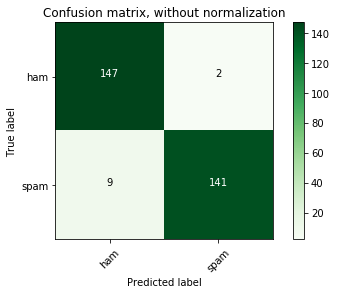

In [162]:
spam_detector1 = MultinomialNB().fit(msg_train1, label_train1)
label_pred_1 = spam_detector1.predict(msg_test1)
print(classification_report(label_test1, label_pred_1))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test1, label_pred_1), classes=spam_detector1.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Greens)
plt.show()

In [50]:
# Классфикатор работает неплохо, ошибок совершает очень мало. Всего 9 спамных письма попали к обычным 
# письмам. Но 2 нормальных писем попали в спам, что не есть хорошо.

In [51]:
# Без пунктуации

In [52]:
from nltk.tokenize import RegexpTokenizer

In [53]:
tokenizer = RegexpTokenizer(r'\w+')
def tokenize_without_punctuation(text):
    text = text.lower()
    return tokenizer.tokenize(text)
bow_transformer = CountVectorizer(tokenizer=tokenize).fit_transform(messages1['message'])

In [163]:
msg_train2, msg_test2, label_train2, label_test2 = train_test_split(bow_transformer, messages1['label'],
                                                               test_size=0.2)

             precision    recall  f1-score   support

        ham       0.98      0.99      0.98       152
       spam       0.99      0.98      0.98       147

avg / total       0.98      0.98      0.98       299

Confusion matrix, without normalization
[[150   2]
 [  3 144]]


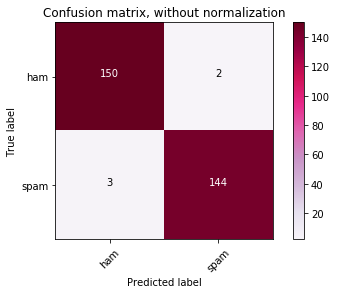

In [164]:
spam_detector2 = MultinomialNB().fit(msg_train2, label_train2)
label_pred_2 = spam_detector1.predict(msg_test2)
print(classification_report(label_test2, label_pred_2))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test2, label_pred_2), classes=spam_detector2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuRd)
plt.show()

In [56]:
# Все характеристики стали лучше, и по confusion matrix видно, что тепрь всего 3 спамных письма попали 
# к нормальным письмам, и всего 2 нормальных письма попали в спам.

In [57]:
# Значит далее всегда удаляем пунктуацию.

In [58]:
# Без пунктуации, с лемматизацией

In [59]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [169]:
def lemmatize(text):
    text = text.lower()
    words = tokenizer.tokenize(text)
    return [lmtzr.lemmatize(w) for w in words]

In [254]:
bow_transformer = CountVectorizer(tokenizer=lemmatize).fit_transform(messages1['message'])
msg_train3, msg_test3, label_train3, label_test3 = train_test_split(bow_transformer, messages1['label'],
                                                               test_size=0.2)

             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       149
       spam       0.99      0.97      0.98       150

avg / total       0.98      0.98      0.98       299

Confusion matrix, without normalization
[[148   1]
 [  5 145]]


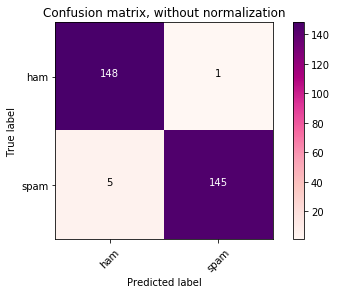

In [183]:
spam_detector3 = MultinomialNB().fit(msg_train3, label_train3)
label_pred_3 = spam_detector3.predict(msg_test3)
print(classification_report(label_test3, label_pred_3))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test3, label_pred_3), classes=spam_detector3.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.RdPu)
plt.show()

In [75]:
# Классификатор не стал работать ни хуже, ни лучше. Все метрики - accuracy, precision, F-measure - такие же. 
# И больше спамовских писем (8) отправляются к нормальным. Но! Всего одно нормальное письмо уходит 
# в корзину спама. Для меня, лично, это важнее, я уж лучше увижу 5 спамовских писем и не увижу
# одно важное, чем увижу всего лишь 3 спамовских письма, но пропущу уже два важных. 
# Поэтому даже не знаю.
# Я, наверное, дальше с лемматизацией пойду.

In [77]:
# Без пунктуации, с лемматизацией, с удалением стоп слов.

In [184]:
def lemmatize_wo_stop(text):
    text = text.lower()
    words = tokenizer.tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    return [lmtzr.lemmatize(w) for w in words]

In [253]:
bow_transformer2 = CountVectorizer(tokenizer=lemmatize_wo_stop).fit_transform(messages1['message'])
msg_train4, msg_test4, label_train4, label_test4 = train_test_split(bow_transformer2, messages1['label'],
                                                               test_size=0.2)

             precision    recall  f1-score   support

        ham       0.95      0.97      0.96       146
       spam       0.97      0.95      0.96       153

avg / total       0.96      0.96      0.96       299

Confusion matrix, without normalization
[[141   5]
 [  7 146]]


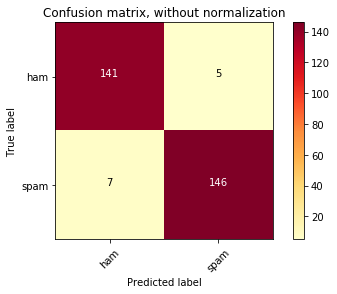

In [186]:
spam_detector4 = MultinomialNB().fit(msg_train4, label_train4)
label_pred_4 = spam_detector4.predict(msg_test4)
print(classification_report(label_test4, label_pred_4))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test4, label_pred_4), classes=spam_detector4.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.YlOrRd)
plt.show()

In [87]:
# Классификатор стал работать хуже по все параметрам, ниже precision, recall, F-measure.
# Больше нормальных писем попало в спам, больше спама попало к нормальным письмам.
# Дальше пойдем без удаления стоп-слов.

In [88]:
# Без пунктуации, с лемматизацией, без удаления стоп-слов, с tfidf-векторизацией.

In [199]:
msg_train5, msg_test5, label_train5, label_test5 = train_test_split(messages1['message'], messages1['label'],
                                                               test_size=0.2)

In [200]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize)
msg_train5 = vectorizer.fit_transform(msg_train5)
msg_test5 = vectorizer.transform(msg_test5)

             precision    recall  f1-score   support

        ham       0.95      0.98      0.96       147
       spam       0.98      0.95      0.96       152

avg / total       0.96      0.96      0.96       299

Confusion matrix, without normalization
[[144   3]
 [  8 144]]


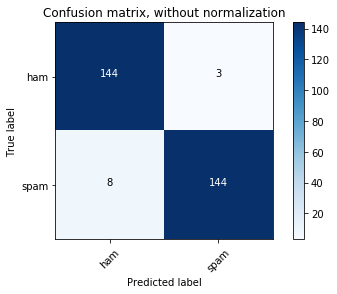

In [201]:
spam_detector5 = MultinomialNB().fit(msg_train5, label_train5)
label_pred_5 = spam_detector5.predict(msg_test5)
print(classification_report(label_test5, label_pred_5))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test5, label_pred_5), classes=spam_detector5.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.Blues)
plt.show()

In [202]:
# Работать лучше чем классификатор не предыдущий, а пред-предыдущий не стал, стал немного хуже.
# Precision, recall, f-measure стали ниже.
# Поэтому мы берем тот классификатор.
# Это пре-предыдущий классификатор с countvectorizer, без пунктуации, с лемматизацией, со стоп-словами.

In [158]:
# Сейчас выведем его опять на экран.

             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       149
       spam       0.99      0.97      0.98       150

avg / total       0.98      0.98      0.98       299

Confusion matrix, without normalization
[[148   1]
 [  5 145]]


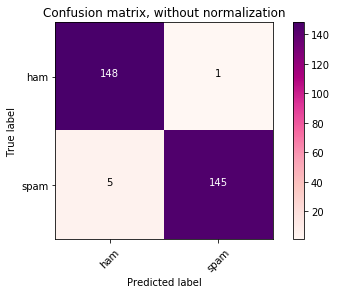

In [203]:
spam_detector3 = MultinomialNB().fit(msg_train3, label_train3)
label_pred_3 = spam_detector3.predict(msg_test3)
print(classification_report(label_test3, label_pred_3))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test3, label_pred_3), classes=spam_detector3.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.RdPu)
plt.show()

In [205]:
# Сравнение с деревом решений.

In [206]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [231]:
splits = [3, 4, 5, 6, 7, 8, 9, 10]
leaves = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = {}
for s in splits:
    for l in leaves:
        result = []
        clf1 = DecisionTreeClassifier(min_samples_split=s, min_samples_leaf=l)
        clf1.fit(msg_train3, label_train3)
        label_pred_clf1 = clf1.predict(msg_test3)
        print(str(s) + ' and ' + str(l))
        print(classification_report(label_test3, label_pred_clf1))

3 and 1
             precision    recall  f1-score   support

        ham       0.93      0.91      0.92       149
       spam       0.91      0.93      0.92       150

avg / total       0.92      0.92      0.92       299

3 and 2
             precision    recall  f1-score   support

        ham       0.88      0.91      0.90       149
       spam       0.91      0.88      0.89       150

avg / total       0.90      0.90      0.90       299

3 and 3
             precision    recall  f1-score   support

        ham       0.91      0.91      0.91       149
       spam       0.91      0.91      0.91       150

avg / total       0.91      0.91      0.91       299

3 and 4
             precision    recall  f1-score   support

        ham       0.87      0.91      0.89       149
       spam       0.91      0.87      0.89       150

avg / total       0.89      0.89      0.89       299

3 and 5
             precision    recall  f1-score   support

        ham       0.92      0.94      0.93    

In [ ]:
# Дерево лучше всего работает, когда min_samples_leaf = 5, и неважно чему равен min_samples_split.
# Возьмем занчения 2 и 5.

             precision    recall  f1-score   support

        ham       0.93      0.94      0.93       149
       spam       0.94      0.93      0.93       150

avg / total       0.93      0.93      0.93       299

Confusion matrix, without normalization
[[140   9]
 [ 11 139]]


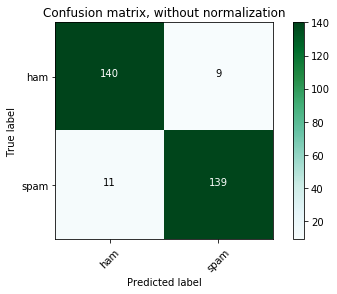

In [234]:
clf = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=5)
clf.fit(msg_train3, label_train3)
label_pred_clf = clf.predict(msg_test3)
print(classification_report(label_test3, label_pred_clf))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test3, label_pred_clf), classes=clf.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.BuGn)
plt.show()

In [235]:
# Дерево работает хуже чем наивный байес по все метрикам.

In [236]:
# Сравнение с лесом решений.

In [237]:
estimators = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
for e in estimators:
    rf1 = RandomForestClassifier(n_estimators=e)
    rf1.fit(msg_train3, label_train3)
    label_pred_rf1 = rf1.predict(msg_test3)
    print('Estimators = ' + str(e))
    print(classification_report(label_test3, label_pred_rf1))
    print('')

Estimators = 10
             precision    recall  f1-score   support

        ham       0.88      1.00      0.94       149
       spam       1.00      0.87      0.93       150

avg / total       0.94      0.93      0.93       299


Estimators = 15
             precision    recall  f1-score   support

        ham       0.94      0.98      0.96       149
       spam       0.98      0.93      0.96       150

avg / total       0.96      0.96      0.96       299


Estimators = 20
             precision    recall  f1-score   support

        ham       0.92      0.99      0.95       149
       spam       0.99      0.92      0.95       150

avg / total       0.96      0.95      0.95       299


Estimators = 25
             precision    recall  f1-score   support

        ham       0.94      0.99      0.96       149
       spam       0.99      0.93      0.96       150

avg / total       0.96      0.96      0.96       299


Estimators = 30
             precision    recall  f1-score   support

  

In [238]:
# Лес при нескольких n_estimators работает лучше всех. Возьмем 50.

             precision    recall  f1-score   support

        ham       0.94      1.00      0.97       149
       spam       1.00      0.94      0.97       150

avg / total       0.97      0.97      0.97       299

Confusion matrix, without normalization
[[149   0]
 [  9 141]]


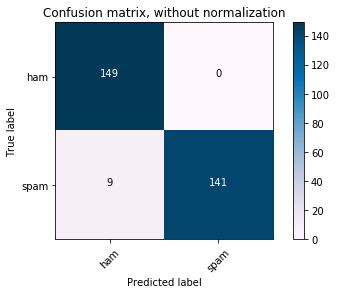

In [239]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(msg_train3, label_train3)
label_pred_rf = rf.predict(msg_test3)
print(classification_report(label_test3, label_pred_rf))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test3, label_pred_rf), classes=rf.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.PuBu)
plt.show()

In [240]:
# По метрикам лес работает немного хуже, чем наивный байес. Но! Он определяет все нормальные письма правильно,
# ни одно нормальное письмо не ушло в спам. Мне это немного важнее. Я уже об этом говорила. Поэтому я бы эту модель использовала.

In [273]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [265]:
msg, label = bow_transformer, messages1['label']

In [276]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

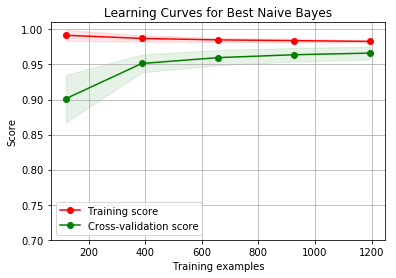

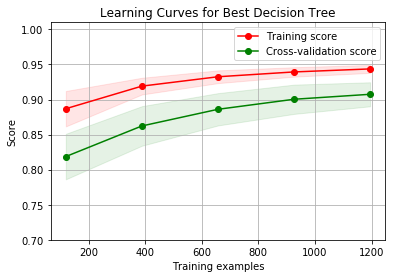

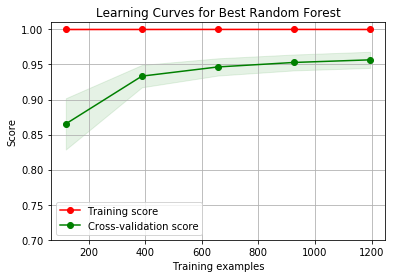

In [278]:
title = "Learning Curves for Best Naive Bayes"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, title, msg, label, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves for Best Decision Tree"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=5)
plot_learning_curve(estimator, title, msg, label, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves for Best Random Forest"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(n_estimators = 50)
plot_learning_curve(estimator, title, msg, label, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [279]:
# Видно, что у дерева решений и training score, и cross-validating score самые низкие из трех. 
# У дерева решений лучший training score, а у наивного байеса самый лучший cross-validating score. 
# У наивного байеса все с большим количеством данных слегка ухудшался training score.

In [303]:
messages1['exclamation'] = messages1['message'].str.count('!')
messages1.groupby(['label']).agg({'exclamation': 'mean'})

,exclamation
label,
ham,0.159304
spam,0.729585


In [304]:
messages1['percent'] = messages1['message'].str.count('%')
messages1.groupby(['label']).agg({'percent': 'mean'})

,percent
label,
ham,0.000000
spam,0.004016


In [305]:
messages1['dash'] = messages1['message'].str.count('-')
messages1.groupby(['label']).agg({'dash': 'mean'})

,dash
label,
ham,0.049531
spam,0.330656


In [307]:
messages1['at'] = messages1['message'].str.count('@')
messages1.groupby(['label']).agg({'at': 'mean'})

,at
label,
ham,0.002677
spam,0.033467


In [341]:
messages1['info'] = messages1['message'].str.count('info')
messages1.groupby(['label']).agg({'info': 'mean'})

,info
label,
ham,0.001339
spam,0.033467


In [342]:
messages1['length'] = messages1['message'].map(lambda text: len(text))

In [346]:
messages1['numbers'] = messages1['message'].str.count('[0-9]')
messages1.groupby(['label']).agg({'numbers': 'mean'})

,numbers
label,
ham,0.266399
spam,15.812584


In [347]:
features = ['exclamation', 'at', 'percent', 'info', 'dash', 'length', 'numbers']

In [350]:
# Наивный Байес

             precision    recall  f1-score   support

        ham       0.91      0.97      0.94       146
       spam       0.97      0.91      0.94       153

avg / total       0.94      0.94      0.94       299

Confusion matrix, without normalization
[[142   4]
 [ 14 139]]


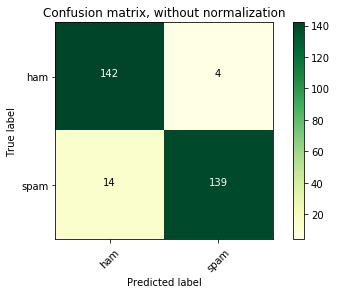

In [348]:
msg_train7, msg_test7, label_train7, label_test7 = train_test_split(messages1[features], messages1['label'],
                                                               test_size=0.2)
spam_detector7 = MultinomialNB().fit(msg_train7, label_train7)
label_pred_7 = spam_detector7.predict(msg_test7)
print(classification_report(label_test7, label_pred_7))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test7, label_pred_7), classes=spam_detector7.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.YlGn)
plt.show()

In [349]:
# Результаты хуже для этих фичей чем для кол-ва вхождения слов, но не намного 

In [ ]:
# Дерево решений

             precision    recall  f1-score   support

        ham       0.94      0.95      0.94       146
       spam       0.95      0.94      0.94       153

avg / total       0.94      0.94      0.94       299

Confusion matrix, without normalization
[[138   8]
 [  9 144]]


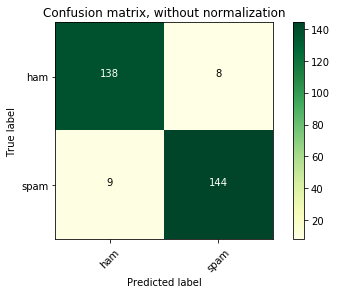

In [354]:
clf2 = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=5)
clf2.fit(msg_train7, label_train7)
label_pred_clf2 = clf2.predict(msg_test7)
print(classification_report(label_test7, label_pred_clf2))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test7, label_pred_clf2), classes=clf2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.YlGn)
plt.show()

In [355]:
# А вот результаты этого дерева лучше (немного) чем результаты того дерева. И это я даже не искала лучшее дерево.

             precision    recall  f1-score   support

        ham       0.92      0.95      0.94       146
       spam       0.95      0.92      0.94       153

avg / total       0.94      0.94      0.94       299

Confusion matrix, without normalization
[[139   7]
 [ 12 141]]


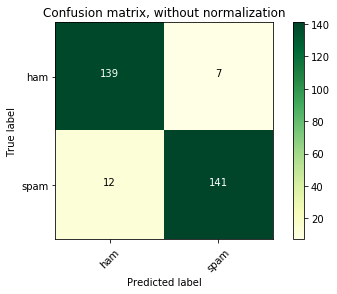

In [358]:
rf2 = RandomForestClassifier(n_estimators=50)
rf2.fit(msg_train7, label_train7)
label_pred_rf2 = rf2.predict(msg_test7)
print(classification_report(label_test7, label_pred_rf2))
plt.figure()
plot_confusion_matrix(confusion_matrix(label_test7, label_pred_rf2), classes=rf2.classes_,
                      title='Confusion matrix, without normalization', cmap=plt.cm.YlGn)
plt.show()

In [ ]:
# Результаты лесв хуже чем того леса. Но я не искала лучший лес в этот раз.